# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import LinAlgError, inv

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')
display(df)

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1732,0,30.0,42300.0,0,0
3504,0,34.0,27200.0,0,0
441,0,36.0,56200.0,1,0
4324,1,28.0,33100.0,0,0
3687,1,33.0,49600.0,0,0
136,0,36.0,41700.0,1,0
2099,1,25.0,23500.0,0,0
3356,1,20.0,46600.0,1,0
1757,0,42.0,35500.0,1,1
3792,0,23.0,43700.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int')

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
print(df.describe())

            gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000  


In [9]:
print(df['insurance_benefits'].unique())

[0 1 2 3 5 4]


I think everything looks okay

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected
    
</div>

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

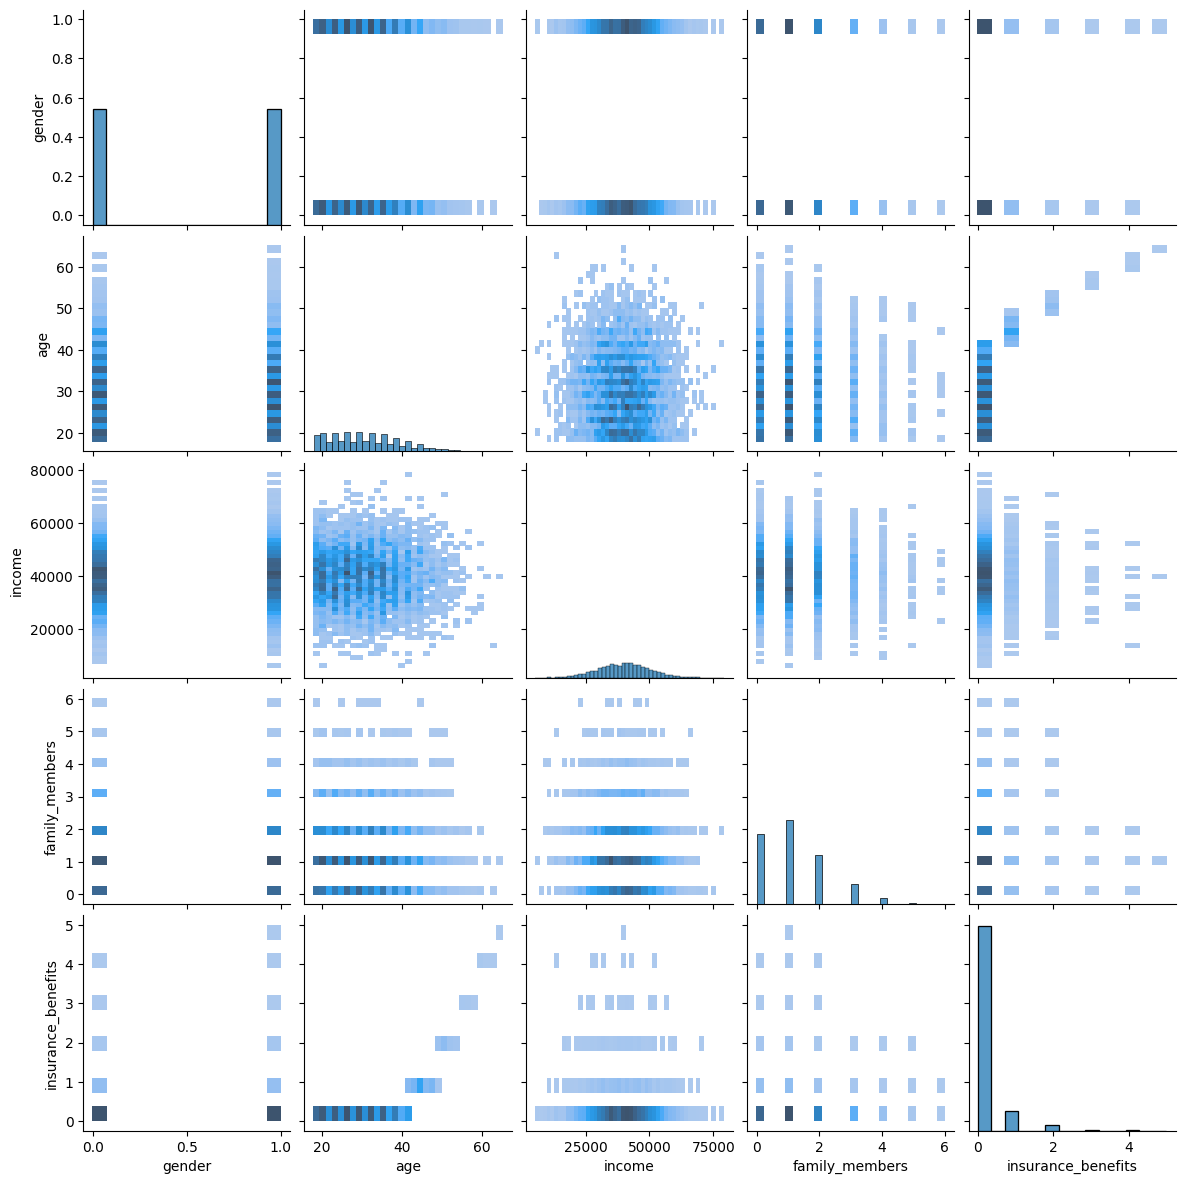

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df.drop('insurance_benefits', axis=1))

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n].drop('insurance_benefits')])

    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    ], axis=1)

    return df_res

<div class="alert alert-success">
<b>Reviewer's comment</b>

The function for finding nearest neighbors is correct
    
    
</div>

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4019,0.0,0.953846,0.178481,0.000000,4
2013,1.0,0.430769,0.622785,0.000000,0
3395,0.0,0.476923,0.429114,0.000000,0
623,1.0,0.630769,0.236709,0.166667,0
3499,1.0,0.338462,0.824051,0.666667,0


Now, let's get similar records for a given one for every combination

In [15]:
# Case 1: Data not scaled, Euclidean distance
result_case1 = get_knn(df, n=0, k=5, metric='euclidean')
print(result_case1)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625


In [16]:
# Case 2: Data not scaled, Manhattan distance
result_case2 = get_knn(df, n=0, k=5, metric='manhattan')
print(result_case2)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0


In [17]:
# Case 3: Data scaled with MaxAbsScaler, Euclidean distance
result_case3 = get_knn(df_scaled, n=0, k=5, metric='euclidean')
print(result_case3)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [18]:
# Case 4: Data scaled with MaxAbsScaler, Manhattan distance
result_case4 = get_knn(df_scaled, n=0, k=5, metric='manhattan')
print(result_case4)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The kNN algorithm relies on distance metrics to find nearest neighbors. If features are on different scales, those with larger magnitudes can skew the distance calculation. Scaling makes sur that all features contribute equally to the distance calculation.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep, that's right!
    
</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
probability_of_benefit = df['insurance_benefits_received'].sum() / len(df)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Target was calculated correctly
    
</div>

In [20]:
# check for the class imbalance with value_counts()

class_counts = df['insurance_benefits_received'].value_counts()
print("Class Imbalance Check:")
print(class_counts)

Class Imbalance Check:
0    4436
1     564
Name: insurance_benefits_received, dtype: int64


In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [22]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, probability_of_benefit, 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1), 
                                                    df['insurance_benefits_received'], 
                                                    test_size=0.3, random_state=42)

In [25]:
# Define a function to build and evaluate kNN classifier for different values of k
def evaluate_knn(features_train, features_test, target_train, target_test, scaled=False):
    f1_scores = []
    for k in range(1, 11):
        if scaled:
            scaler = sklearn.preprocessing.MaxAbsScaler()
            features_train_scaled = scaler.fit_transform(features_train)
            features_test_scaled = scaler.transform(features_test)
        else:
            features_train_scaled = features_train
            features_test_scaled = features_test
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(features_train_scaled, target_train)
        target_pred = knn.predict(features_test_scaled)
        f1_scores.append(f1_score(target_test, target_pred))
    return f1_scores

<div class="alert alert-success">
<b>Reviewer's comment</b>

Scaling is applied correctly!
    
</div>

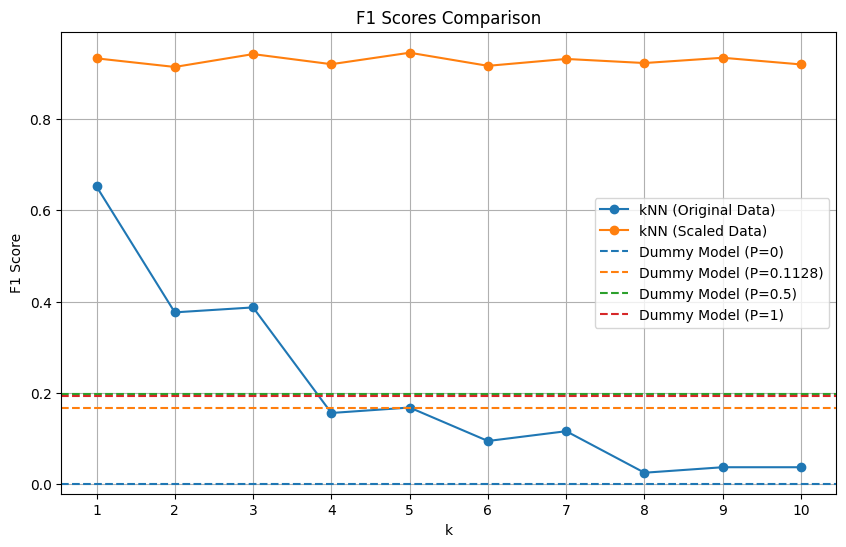

In [26]:
# Calculate F1 scores for the kNN classifier (original data)
f1_scores_original = evaluate_knn(features_train, features_test, target_train, target_test, scaled=False)

# Calculate F1 scores for the kNN classifier (scaled data)
f1_scores_scaled = evaluate_knn(features_train, features_test, target_train, target_test, scaled=True)

# Calculate F1 scores for the dummy model for different probability values
dummy_f1_scores = []
for prob in [0, probability_of_benefit, 0.5, 1]:
    y_pred_rnd = rnd_model_predict(prob, len(target_test))
    f1_score_dummy = sklearn.metrics.f1_score(target_test, y_pred_rnd)
    dummy_f1_scores.append(f1_score_dummy)

# Plot F1 scores for kNN classifier and dummy model
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), f1_scores_original, marker='o', label='kNN (Original Data)')
plt.plot(range(1, 11), f1_scores_scaled, marker='o', label='kNN (Scaled Data)')

# Plot dummy model F1 scores for different probability values
for i, prob in enumerate([0, probability_of_benefit, 0.5, 1]):
    plt.axhline(y=dummy_f1_scores[i], linestyle='--', color='C'+str(i), label=f'Dummy Model (P={prob})')

plt.title('F1 Scores Comparison')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

The kNN function with the scaled data highly outperforms the kNN with the original data and the dummy model. The kNN model with original data gradually gets worse with each additional 'k'.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully applied kNN to a classification problem and compared the results with and without scaling. Nice illustration of the importance of scaling for distance-based algorithms!
    
</div>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

<div class="alert alert-success">
<b>Reviewer's comment</b>

Linear regression was implemented correctly
    
</div>

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
# Prepare the data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Initialize and fit the linear regression model on the original data
lr_original = MyLinearRegression()
lr_original.fit(X_train, y_train)

# Predict on the test set for the original data and evaluate the model
y_test_pred_original = lr_original.predict(X_test)
print("Evaluation on Original Data:")
eval_regressor(y_test, y_test_pred_original)
print()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the linear regression model on the scaled data
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

# Predict on the test set for the scaled data and evaluate the model
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
print("Evaluation on Scaled Data:")
eval_regressor(y_test, y_test_pred_scaled)

Evaluation on Original Data:
RMSE: 0.34
R2: 0.66

Evaluation on Scaled Data:
RMSE: 0.34
R2: 0.66


The LinearRegression model performed identically for the scaled and original data. The performance is relatively good, with an RMSE of 0.34 and an R2 score of 0.66. This indicates that the model explains approximately 66% of the variance in the target variable, which suggests a reasonably good fit to the data.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Indeed! Note that scaling can be useful for linear regression for example if we apply L1 or L2 regularization or fit the model using the stochastic gradient descent
    
</div>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [30]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [31]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [32]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [33]:
# Check if matrix P is invertible
is_invertible = np.linalg.matrix_rank(P) == X.shape[1]
print("Is matrix P invertible?", is_invertible)

Is matrix P invertible? True


Can you guess the customers' ages or income after the transformation?

In [34]:
# Perform matrix multiplication X' = X * P
X_transformed = X @ P
print(X_transformed)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


You cannot guess the customers' ages or income after the transformation

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [35]:
P_inverse = np.linalg.inv(P)
X_recovered = X_transformed @ P_inverse
print(X_recovered)
print()
print(X)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


The original data is recoverable.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct!
    
</div>

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [36]:
# Print a few samples of the original, transformed, and recovered data
print("Original Data:")
print(X[:3])
print("\nTransformed Data:")
print(X_transformed[:3])
print("\nRecovered Data:")
print(X_recovered[:3])

Original Data:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]

Transformed Data:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]

Recovered Data:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Maybe because there's limitations in how precise the numbers can be?

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep, floating point numbers have limited precision, that's why error inevitably accumulates whenever we do any operations on them.
    
</div>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

# Relationship Between $ w $ and $ w_P $

For the obfuscated data, the weight vector $ w_P $ is:
$
w_P = [(X P)^T (X P)]^{-1} (X P)^T y
$

Which is then simplified to: $
w_P = [P^TX^TXP]^{-1}P^TX^Ty
$

Using the property of matrix inverses:
$
w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$

Since $(P^T (P^T)^{-1} = I)$ (the identity matrix):
$[w_P = P^{-1} (X^T X)^{-1} X^T y]$

Therefore, the relationship between $w$ and $w_P$ is:
$w_P = P^{-1} w$

# Predicted Values with $w_P$

To find the predicted values using the obfuscated data \( X' \) and the weight vector \( w_P \):
$\hat{y}_P = X' w_P = (X P) w_P$

Substituting $w_P = P^{-1} w$:

$\hat{y}_P = (X P) (P^{-1} w)$

$\hat{y}_P = X (P P^{-1}) w$

$\hat{y}_P = X I w$

$\hat{y}_P = X w$

This shows that the predicted values $\hat{y}_P$ using the obfuscated data and the new weights $w_P$ are the same as the predicted values $\hat{y}$ using the original data and weights $w$.

# Implications for RMSE

Since the predicted values remain the same, the root mean squared error (RMSE) will also remain the same. RMSE is calculated as:
$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2}$

If $\hat{y}_P = \hat{y}$, then:
$\text{RMSE}_P = \text{RMSE}$

This means that obfuscating the data by multiplying the feature matrix $X$ by an invertible matrix $P$ does not affect the quality of the linear regression model as measured by RMSE.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The proof is correct! Excellent work!
    
</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [37]:
# Function to generate an invertible matrix
def generate_invertible_matrix(size, seed=42):
    rng = np.random.default_rng(seed)
    while True:
        P = rng.random((size, size))
        try:
            # Check if P is invertible
            inv(P)
            return P
        except LinAlgError:
            continue

In [38]:
# Class for linear regression with optional obfuscation
class ObfuscatedLinearRegression:
    def __init__(self, obfuscate=False):
        self.obfuscate = obfuscate
        self.P = None
        self.model = MyLinearRegression()

    def fit(self, X, y):
        if self.obfuscate:
            # Generate invertible matrix P
            self.P = generate_invertible_matrix(X.shape[1])
            # Obfuscate X
            X = np.dot(X, self.P)
        self.model.fit(X, y)

    def predict(self, X):
        if self.obfuscate and self.P is not None:
            X = np.dot(X, self.P)
        return self.model.predict(X)

In [39]:
# Function to evaluate the model
def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.2f}')
    return rmse, r2

In [40]:
# Evaluate original data
print("Evaluation on Original Data:")
lr_original = ObfuscatedLinearRegression(obfuscate=False)
lr_original.fit(X_train, y_train)
y_pred_original = lr_original.predict(X_test)
rmse_original, r2_original = eval_regressor(y_test, y_pred_original)

# Evaluate obfuscated data
print("\nEvaluation on Obfuscated Data:")
lr_obfuscated = ObfuscatedLinearRegression(obfuscate=True)
lr_obfuscated.fit(X_train, y_train)
y_pred_obfuscated = lr_obfuscated.predict(X_test)
rmse_obfuscated, r2_obfuscated = eval_regressor(y_test, y_pred_obfuscated)

# Compare predicted values
print("\nComparison of Predicted Values:")
print("Original Predicted Values:", y_pred_original[:5])
print("Obfuscated Predicted Values:", y_pred_obfuscated[:5])

# Comparison of RMSE and R2
print("\nComparison of Metrics:")
print(f"RMSE Original: {rmse_original:.2f}, RMSE Obfuscated: {rmse_obfuscated:.2f}")
print(f"R2 Original: {r2_original:.2f}, R2 Obfuscated: {r2_obfuscated:.2f}")

Evaluation on Original Data:
RMSE: 0.34
R2: 0.43

Evaluation on Obfuscated Data:
RMSE: 0.34
R2: 0.43

Comparison of Predicted Values:
Original Predicted Values: [ 0.17926625  0.80931996  0.45614337 -0.23762191  0.4650019 ]
Obfuscated Predicted Values: [ 0.1792662   0.80931996  0.45614341 -0.23762189  0.46500185]

Comparison of Metrics:
RMSE Original: 0.34, RMSE Obfuscated: 0.34
R2 Original: 0.43, R2 Obfuscated: 0.43


The predicted values, the RMSE, and 𝑅2 metric values are exactly the same for the original and the obfuscated data besides some very minor differences in the values.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The experiment was conducted correctly!
    
</div>

# Conclusions

**Manhattan Distance Metric Consistency:**

The results using the Manhattan distance metric are similar regardless of scaling.
Despite feature scale differences between unscaled and MaxAbsScaler-scaled data, nearest neighbors identified using Manhattan distance show consistency.
This suggests Manhattan distance is less sensitive to feature scaling, making it suitable for data with different scales.

**kNN Performance:**

The kNN classifier with scaled data significantly outperforms both the kNN with original data and the dummy model.
Performance of the kNN model on original data deteriorates with increasing 'k'.

**Linear Regression Performance:**

The LinearRegression model performs identically on both scaled and original data, with an RMSE of 0.34 and an R2 score of 0.66.
The model explains approximately 66% of the variance in the target variable, indicating a reasonably good fit.

**Data Obfuscation:**

Customer ages or income cannot be guessed after the data transformation.
The original data is recoverable from the transformed data.

**Effect of Obfuscation on Linear Regression:**

Linear Regression works computationally with the obfuscation transformation.
Predicted values, RMSE, and R2 metrics are the same for both original and obfuscated data, apart from minor numerical differences.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary!
    
</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>